In [ ]:
from google.colab import drive
import zipfile
import os

MOUNT_DIR = '/content/drive'
DATA_DIR_SMALLER = '/content/drive/MyDrive/kaggle/DatasetSmaller.zip'
EXTRACTED_DIR = '/content/dataFolder'
# # Mount Google Drive
drive.mount(MOUNT_DIR, force_remount=False)
# Path to the zip file in your Google Drive
zip_file_path = DATA_DIR_SMALLER

# # Directory to extract the contents
extracted_dir_path = EXTRACTED_DIR


def extract_data(extracted_dir_path):
#   # Extract the zip file
   with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
       zip_ref.extractall(extracted_dir_path)

extract_data(extracted_dir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import Subset


# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# You could add your own libraries from Python Standard Library in this cell. Any other external libraries are not allowed.
import os

In [ ]:
class ChestDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs


    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # print("Image size before transformation:", image.size)

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        # print("Image size after transformation:", image.shape)

        return image, label

def get_dataset(root):
    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load datasets for training, validation, and test with size (224, 224)
    dataset = ChestDataset(path=root, transform=transform)

    # Compute mean and std for normalization
    def compute_mean_and_std(dataset):
        mean_sum = np.zeros(3)
        std_sum = np.zeros(3)
        num_samples = len(dataset)

        for img, _ in dataset:
            img = np.array(img)
            # Compute mean along height and width axes
            img_mean = np.mean(img, axis=(1, 2))
            # Compute std along height and width axes
            img_std = np.std(img, axis=(1, 2))

            mean_sum += img_mean
            std_sum += img_std

        # Compute overall mean and std across all images
        mean = mean_sum / num_samples
        std = std_sum / num_samples

        return mean, std

    train_mean, train_std = compute_mean_and_std(dataset)

    # Apply normalization with computed mean and std
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std)
    ])

    # Apply normalization to datasets
    dataset.transform = transform

    return dataset

In [ ]:
class CNN(nn.Module):
    '''Define your neural network'''
    def __init__(self, **kwargs): # you can add any additional parameters you want

    # Out size calculation for Conv2d & MaxPool2d: [(W−K+2P)/S]+1
        super().__init__()
        self.cnn_model = nn.Sequential(
            # In: 3 x 224 x 224 --> Out [(224 - 3 + 2 * 1) / 1] + 1 = 224 ==>  32 x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # In: 32 x 224 x 224 --> Out [(224 - 3 + 2 * 0) / 3] + 1 = 74 ==>  32 x 74 x 74
            nn.MaxPool2d(kernel_size=3),

            # In: 32 x 74 x 74 --> Out [(74 - 3 + 2 * 1) / 1] + 1 = 74 ==>  64 x 74 x 74
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # In: 64 x 74 x 74 --> Out [(74 - 3 + 2 * 0) / 3] + 1 = 24 ==>  64 x 24 x 24
            nn.MaxPool2d(kernel_size=3),

            # In: 64 x 24 x 24 --> Out [(24 - 3 + 2 *ş 1) / 1] + 1 = 24 ==>  128 x 24 x 24
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # In: 128 x 24 x 24 --> Out [(24 - 3 + 2 * 0) / 3] + 1 = 8 ==>  128 x 8 x 8
            nn.MaxPool2d(kernel_size=3),

            # In: 128 x 8 x 8 --> Out 128 * 8 * 8 = 8192 ==>  1 x 8192
            nn.Flatten(),
            nn.Linear(8192, 5),
            nn.Softmax(dim=-1),
        )

    def forward(self, X): # you can add any additional parameters you want
        return self.cnn_model(X)

In [ ]:
def get_loaders(data_foldername, train_batch=64, test_batch=64, val_batch=64):
    # Create the full dataset
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dataset = get_dataset(dataset_path)

    # Assume each data point is a tuple (image, label) and collect the labels
    labels = [label for _, label in dataset]

    # Generate indices: full range of dataset
    full_indices = list(range(len(dataset)))

    # First split: separate out the test set
    train_val_indices, test_indices = train_test_split(
        full_indices, test_size=0.1, stratify=labels, random_state=42
    )

    # Adjust the labels and indices for the next split by filtering out test indices
    train_val_labels = [labels[i] for i in train_val_indices]

    # Second split: split the remaining data into train and validation sets
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=(0.1 / 0.9), stratify=train_val_labels, random_state=42
    )

    # Create subsets for train, validation, and test
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create dataset loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch)
    val_loader = DataLoader(dataset=val_dataset, batch_size=val_batch)

    return train_loader, test_loader, val_loader

def get_num_of_classes(data_foldername):
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dummy_dataset = ChestDataset(path=dataset_path)
    num_of_classes = len(dummy_dataset.data.classes)

    return num_of_classes

def train_for_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

def validate_for_epoch(model, val_loader, loss_fn, device):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return val_loss / len(val_loader), accuracy

def train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path):
    best_val_loss = float('inf')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(max_epoch):
        # Training
        train_loss, train_accuracy = train_for_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # Corrected variable name

        # Validation
        val_loss, val_accuracy = validate_for_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{max_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save best model according to validation performance
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)


    history = {'train_losses': train_losses, 'train_accuracies': train_accuracies, 'val_losses': val_losses, 'val_accuracies': val_accuracies}

    return history

def plot_losses(history):
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses vs Epoch')
    plt.legend()
    plt.show()

def plot_accuracies(history):
    plt.plot(history['train_accuracies'], label='Train Accuracy')
    plt.plot(history['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

def load_best_model(model_path):
    state_dict = torch.load(model_path)
    # Instantiate your model
    model = CNN()
    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def load_best_model_transfer(model_path, data_foldername):
    state_dict = torch.load(model_path)

    # Instantiate your model with MobileNet
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # Replace the classifier of MobileNet
    num_features = model.classifier[1].in_features
    num_classes = get_num_of_classes(data_foldername)
    model.classifier[1] = nn.Linear(num_features, num_classes)

    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def test_model(model, test_loader, device):
    model.eval()
    loss_func = nn.CrossEntropyLoss()

    all_predictions = []
    all_targets = []
    all_losses = []
    all_probs = [] # for roc-auc

    # Move model to device
    model.to(device)

    # Disable gradients for evaluation
    with torch.no_grad():
        for images, targets in test_loader:
            # Move images and targets to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(images)
            # Compute loss
            loss = loss_func(outputs, targets)
            all_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Get probabilities
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(outputs)
            all_probs.extend(probs.cpu().numpy())

    # Convert targets and predictions to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    #print(all_probs)

    return all_losses, all_predictions, all_targets, all_probs

def calculate_metrics(all_losses, all_predictions, all_targets):
    # Calculate evaluation metrics
    mean_loss = np.mean(all_losses)
    acc = accuracy_score(all_targets, all_predictions)
    pre = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Return metric results as a dictionary
    metrics = {
        'mean_loss': mean_loss,
        'accuracy': acc,
        'precision': pre,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

def plot_confusion_matrix(conf_matrix):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_auc(targets, probs):
    num_classes = probs.shape[1]
    plt.figure(figsize=(8, 6))
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    for i in range(num_classes):
        # Create binary target for the current class
        binary_targets = np.array(targets == i, dtype=int)
        fpr, tpr, _ = roc_curve(binary_targets, probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (class {}) (AUC = {:.2f})'.format(classes[i], roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Epoch [1/40], Train Loss: 1.6644, Train Accuracy: 0.1800, Val Loss: 1.6578, Val Accuracy: 0.2600
Epoch [2/40], Train Loss: 1.6104, Train Accuracy: 0.2437, Val Loss: 1.6157, Val Accuracy: 0.2700
Epoch [3/40], Train Loss: 1.5748, Train Accuracy: 0.2825, Val Loss: 1.5806, Val Accuracy: 0.2900
Epoch [4/40], Train Loss: 1.5392, Train Accuracy: 0.3187, Val Loss: 1.5625, Val Accuracy: 0.3200
Epoch [5/40], Train Loss: 1.5080, Train Accuracy: 0.3450, Val Loss: 1.5664, Val Accuracy: 0.3100
Epoch [6/40], Train Loss: 1.4840, Train Accuracy: 0.3800, Val Loss: 1.5318, Val Accuracy: 0.3600
Epoch [7/40], Train Loss: 1.4469, Train Accuracy: 0.4213, Val Loss: 1.5130, Val Accuracy: 0.3400
Epoch [8/40], Train Loss: 1.4281, Train Accuracy: 0.4412, Val Loss: 1.5214, Val Accuracy: 0.3600
Epoch [9/40], Train Loss: 1.3986, Train Accuracy: 0.4650, Val Loss: 1.4799, Val Accuracy: 0.3900
Epoch [10/40], Train Loss: 1.3641, Train Accuracy: 0.5112, Val Loss: 1.4939, Val Accuracy: 0.4200
Epoch [11/40], Train Loss: 1.

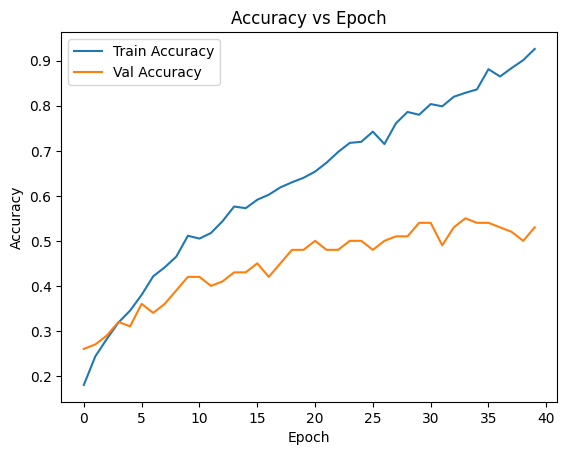

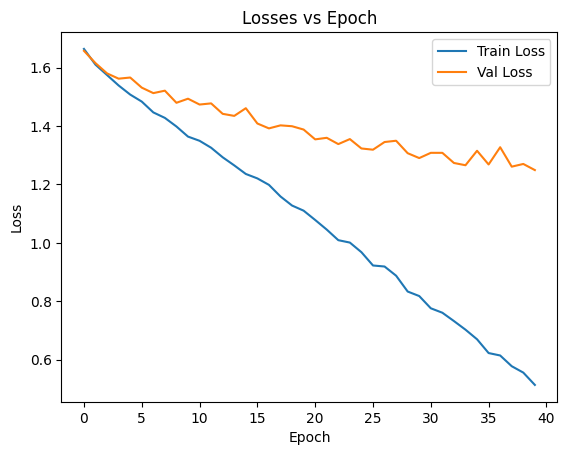

In [ ]:
# HINT: note that your training time should not take more than 2 hours.

# TODO:
# Pick your hyper parameters
max_epoch = 40
train_batch = 32
val_batch = 32
test_batch = 32
learning_rate = 1e-3
weight_decay = 5e-04

# Get dataset loaders
data_foldername = 'dataFolder/folder'
train_loader, test_loader, val_loader = get_loaders(data_foldername, train_batch, test_batch, val_batch)

# initialize your network
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.cuda.empty_cache()
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).to(device)

num_features = model.classifier[1].in_features
num_classes = get_num_of_classes(data_foldername)
model.classifier[1] = nn.Linear(num_features, num_classes).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# start training
history = train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path=f'best_mobilenet_sgd.pth')

# Plot losses vs epoch
plot_accuracies(history)

# Plot accuracies vs epoch
plot_losses(history)

[[0.21178432 0.08736267 0.14337994 0.4789185  0.07855453]
 [0.12878749 0.03202388 0.0959753  0.7280584  0.01515489]
 [0.11720064 0.5006741  0.07059539 0.01998529 0.29154456]
 [0.6150748  0.09086125 0.07485425 0.19146042 0.02774925]
 [0.07800867 0.21503544 0.26496905 0.10094064 0.34104624]
 [0.2294199  0.37143558 0.09936918 0.1637869  0.13598843]
 [0.23727119 0.10396087 0.16328536 0.07388313 0.42159948]
 [0.01946739 0.07230694 0.1319936  0.55328363 0.22294846]
 [0.10122039 0.18164761 0.09462007 0.6067158  0.01579611]
 [0.24471065 0.05018507 0.23575602 0.1926829  0.2766653 ]
 [0.01353231 0.3984022  0.10969873 0.00881009 0.4695566 ]
 [0.4439474  0.01502618 0.42383048 0.02983886 0.08735707]
 [0.09277654 0.0982949  0.24538347 0.544565   0.01898005]
 [0.12585983 0.12560166 0.40538135 0.22459045 0.11856673]
 [0.24500804 0.5255802  0.05425325 0.10814524 0.06701317]
 [0.14070803 0.39748374 0.12329473 0.09515384 0.24335961]
 [0.19325042 0.04793354 0.5232703  0.13963786 0.09590787]
 [0.14808936 0

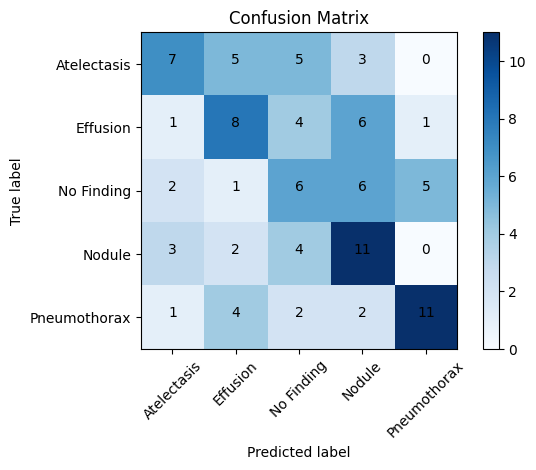

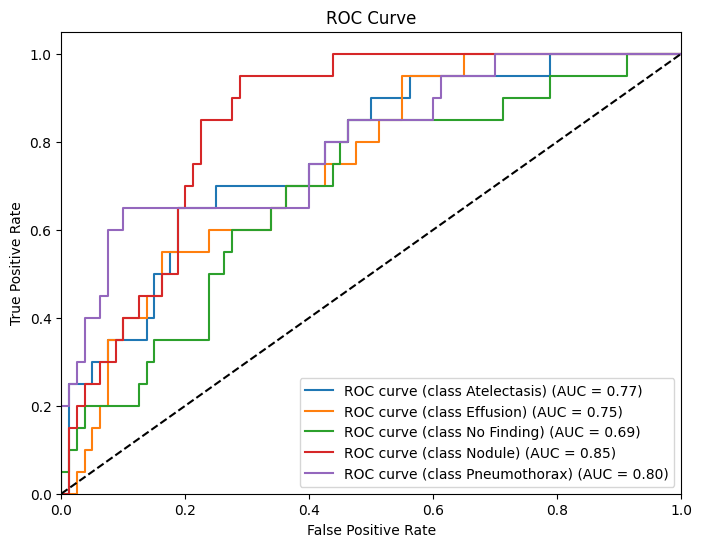

In [ ]:
# Test CNN
# load best model

best_path = os.path.join(os.getcwd(), 'best_mobilenet_sgd.pth')

model = load_best_model_transfer(best_path, data_foldername)

# evaluate on test set
losses, predictions, targets, probs = test_model(model, test_loader, device)
metrics = calculate_metrics(losses, predictions, targets)

# Print metrics
print("Mean Loss: {:.4f}\nAccuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
    metrics['mean_loss'], metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

# plot confusion matrix
conf_matrix = confusion_matrix(targets, predictions)
plot_confusion_matrix(conf_matrix)

# plot ROC-AUC curves
plot_roc_auc(targets, probs)